this notebook is the stacking of my highest score's notebook (72040) The main improvement is adding this feature: oof difference between MSE and MAE

and this public notebook[https://www.kaggle.com/code/allegich/price-cars-prediction-eda-blending/notebook#About-this-competition](http://), Thanks a lot! @Allegich

I would greatly appreciate it if you would consider upvote.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from catboost import CatBoostRegressor, Pool

from sklearn.svm import SVR
from xgboost import XGBRegressor



import random

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import optuna

USE_OPTUNA = False

In [2]:
!python /kaggle/usr/lib/lgbm_cat/lgbm_cat.py 

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 11
[LightGBM] [Info] Start training from score 43824.155038
Training until validation scores don't improve for 200 rounds
[150]	train's l2: 4.74867e+09	valid's l2: 5.66054e+09
[300]	train's l2: 4.38439e+09	valid's l2: 5.67473e+09
Early stopping, best iteration is:
[183]	train's l2: 4.6549e+09	valid's l2: 5.65474e+09
LGBM Fold RMSE: 75198.03022229091
0:	learn: 77841.1784444	test: 80577.0638483	best: 80577.0638483 (0)	total: 6.34s	remaining: 1h 45m 33s
300:	learn: 65498.4982910	t

In [3]:
sub_1 = pd.read_csv("/kaggle/working/submission_1.csv")

In [4]:
sub_2 = pd.read_csv("/kaggle/input/price-cars-prediction-eda-blending/submission.csv")

In [5]:
%%time

sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e9/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
Original = pd.read_csv('/kaggle/input/used-car-price-prediction-dataset/used_cars.csv')

train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

Original[['milage', 'price']] = Original[['milage', 'price']].map(
    lambda x: int(''.join(re.findall(r'\d+', x))))

train = pd.concat([train, Original], ignore_index=True)

CPU times: user 909 ms, sys: 109 ms, total: 1.02 s
Wall time: 1.02 s


In [6]:
def extract_age_features(df):
    current_year = 2024

    df['Vehicle_Age'] = current_year - df['model_year']
    
    df['Mileage_per_Year'] = df['milage'] / df['Vehicle_Age']
    df['milage_with_age'] =  df.groupby('Vehicle_Age')['milage'].transform('mean')
    
    df['Mileage_per_Year_with_age'] =  df.groupby('Vehicle_Age')['Mileage_per_Year'].transform('mean')
 
#     df['milage_brand'] =  df.groupby('brand')['milage'].transform('mean')
    
    
    return df

In [7]:
def extract_engine_features(df):
    
    def extract_horsepower(engine):
        try:
            return float(engine.split('HP')[0])
        except:
            return None

    def extract_engine_size(engine):
        try:
            return float(engine.split(' ')[1].replace('L', ''))
        except:
            return None

    df['Horsepower'] = df['engine'].apply(extract_horsepower)
    df['Engine_Size'] = df['engine'].apply(extract_engine_size)
    df['Power_to_Weight_Ratio'] = df['Horsepower'] / df['Engine_Size']
    
    return df

In [8]:
def extract_other_features(df):
    
    luxury_brands =  ['Mercedes-Benz', 'BMW', 'Audi', 'Porsche', 'Land', 
                    'Lexus', 'Jaguar', 'Bentley', 'Maserati', 'Lamborghini', 
                    'Rolls-Royce', 'Ferrari', 'McLaren', 'Aston', 'Maybach']
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
#     df['luxary_with_accident'] = df.apply(lambda row: 1 if row['Is_Luxury_Brand'] == 1  and row['accident'] == 'At least 1 accident or damage reported' else 0  ,  axis =1)
    
#     df.drop(columns = ['Is_Luxury_Brand'] , inplace=True)



    return df

In [9]:
%%time

train = extract_age_features(train)
test = extract_age_features(test)

# train = extract_engine_features(train)
# test = extract_engine_features(test)

train = extract_other_features(train)
test = extract_other_features(test)


CPU times: user 262 ms, sys: 1.18 ms, total: 263 ms
Wall time: 263 ms


In [10]:
train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,milage_with_age,Mileage_per_Year_with_age,Is_Luxury_Brand
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,12529.411765,118194.992360,6952.646609,0
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,6511.363636,118270.783105,5375.944687,0
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,6215.045455,118270.783105,5375.944687,0
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,7,2785.714286,67981.161419,9711.594488,0
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,2462.666667,29327.437406,9775.812469,1


In [11]:
def update(df):
    
    t = 100
    
    cat_c = ['brand','model','fuel_type','engine','transmission','ext_col','int_col','accident','clean_title',
             
            ]
    re_ = ['model','engine','transmission','ext_col','int_col']
    
    for col in re_:
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < t, col] = "noise"
        
    for col in cat_c:
        df[col] = df[col].fillna('missing')
        df[col] = df[col].astype('category')
        
    return df

train  = update(train)
test   = update(test)

X = train.drop('price', axis=1)
y = train['price']

In [12]:
import numpy as np
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold



callbacks = [log_evaluation(period=300), early_stopping(stopping_rounds=200)]

cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"cat_cols--------{cat_cols}")


def get_MAE_oof(df, target, lgb_params, cat_params=None, model_type='LGBM'):

    
    oof_predictions = np.zeros(len(df))
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    models = []
    rmse_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"Training fold {fold + 1}/{5} with {model_type}")

        X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
        y_train, y_val = target.iloc[train_idx], target.iloc[val_idx]

        if model_type == 'LGBM':
            train_data = lgb.Dataset(X_train, label=y_train)
            val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
            
            model = lgb.train(
                lgb_params,
                train_data,
                valid_sets=[train_data, val_data],
                valid_names=['train', 'valid'],
                callbacks=callbacks    
            )
        
        elif model_type == 'CAT':
            train_data = Pool(data=X_train, label=y_train , cat_features=cat_cols)
            val_data = Pool(data=X_val, label=y_val , cat_features=cat_cols )
            
            model = CatBoostRegressor(**cat_params)
            model.fit(train_data, eval_set=val_data, verbose=150, early_stopping_rounds=200)
        
        models.append(model)
        
        if model_type == 'LGBM':
            pred = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'CAT':
            pred = model.predict(X_val)
        
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        rmse_scores.append(rmse)

        print(f'{model_type} Fold RMSE: {rmse}')
        
        oof_predictions[val_idx] = pred
        
    print(f'Mean RMSE: {np.mean(rmse_scores)}')
    return oof_predictions, models




lgb_params = {
    'objective': 'MAE',
    'n_estimators': 1000,
    'random_state': 42,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')
X['LGBM_MAE'] = oof_predictions_lgbm


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MAE'] = LGBM_preds



lgb_params = {
    'objective': 'MSE',
    'n_estimators': 1000,
    'random_state': 42,
}

oof_predictions_lgbm, models_lgbm = get_MAE_oof(X, y, lgb_params, model_type='LGBM')

X['LGBM_MSE_diff'] = oof_predictions_lgbm - X['LGBM_MAE']


LGBM_preds = np.zeros(len(test))
for model in models_lgbm:
    LGBM_preds += model.predict(test) / len(models_lgbm)
test['LGBM_MSE_diff'] = LGBM_preds - test['LGBM_MAE']

cat_cols--------['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Training fold 1/5 with LGBM
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1724
[LightGBM] [Info] Number of data points in the train set: 154033, number of used features: 16
[LightGBM] [Info] Start training from score 30775.000000
Training until validation scores don't improve for 200 rounds
[300]	train's l1: 16276	valid's l1: 17275.2
[600]	train's l1: 16059.5	valid's l1: 17275.1
Early stopping, best iteration is:
[521]	train's l1: 16108.6	valid's l1: 17271.6
LGBM Fold RMSE: 76012.31926267133
Trai

In [13]:

def objective_lgb(trial):   
    lgb_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'subsample': trial.suggest_uniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.2, 1.0),
        'n_estimators': 1000,
        'random_state': 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(lgb_params, 
                          train_data, 
                          valid_sets=[val_data], 
                          callbacks=callbacks
                         )

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

def objective_cat(trial):

    cat_params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 5, 16),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
        'iterations': 1000,
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'cat_features': cat_cols,
        'random_seed': 42,
        'task_type': 'GPU',
        'early_stopping_rounds': 200
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores_cat = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        train_pool = Pool(X_train, y_train, cat_features=cat_cols)
        val_pool = Pool(X_val, y_val, cat_features=cat_cols)
        
        model_cat = CatBoostRegressor(**cat_params)
        model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
        
        y_pred_cat = model_cat.predict(X_val)
        rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
        rmse_scores_cat.append(rmse_cat)
    
    return np.mean(rmse_scores_cat)

if USE_OPTUNA==True:
    study_lgb = optuna.create_study(direction='minimize')
    study_lgb.optimize(objective_lgb, n_trials=20)

    print("Best LGBM Parameters: ", study_lgb.best_params)
    print("Best LGBM RMSE: ", study_lgb.best_value)

    study_cat = optuna.create_study(direction='minimize')
    study_cat.optimize(objective_cat, n_trials=2)

    print("Best CatBoost Parameters: ", study_cat.best_params)
    print("Best CatBoost RMSE: ", study_cat.best_value)


In [14]:
lgb_params_1 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'extra_tree' : True,
    'verbose' : -1
}

lgb_params_2 ={

    'learning_rate': 0.017521301504983752,
    'max_depth': 42,
    'reg_alpha': 0.06876635751774487, 
    'reg_lambda': 9.738899198284985,
    'num_leaves': 131,
    'subsample': 0.2683765421728044,
    'colsample_bytree': 0.44346036599709887,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose' : -1
}

cat_params={
    'learning_rate':0.042,
    'iterations':1000,
    'depth':10,
    'random_strength' : 10,
    'cat_features':cat_cols,
    'l2_leaf_reg':0.3,
    'random_seed':42,
    'early_stopping_rounds': 200,
    'task_type':'GPU',
}



kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
rmse_scores_cat = []
LGBM_model=[]
CAT_model =[]

callbacks = [log_evaluation(period=150), early_stopping(stopping_rounds=200)]

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    model_1 = lgb.train(lgb_params_1,
                      train_data,
                      valid_sets=[train_data, val_data],
                      valid_names=['train', 'valid'],
                      callbacks=callbacks        
                      )
    model_2 = lgb.train(lgb_params_2,
                  train_data,
                  valid_sets=[train_data, val_data],
                  valid_names=['train', 'valid'],
                  callbacks=callbacks        
                  )
    
    LGBM_model.append(model_1)
    LGBM_model.append(model_2)

    y_pred = model_1.predict(X_val) * 0.5 + model_2.predict(X_val) * 0.5
    

    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    
    print(f'LGBM Fold RMSE: {rmse}')
    
    
    model_cat = CatBoostRegressor(**cat_params)
    

    train_pool = Pool(X_train, y_train ,cat_features=cat_cols)
    val_pool = Pool(X_val, y_val , cat_features=cat_cols)
    model_cat.fit(train_pool, eval_set=val_pool, verbose=300)
    
    CAT_model.append(model_cat)
    y_pred_cat = model_cat.predict(X_val)
    rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
    rmse_scores_cat.append(rmse_cat)
    
    print(f'CAT Fold RMSE: {rmse_cat}')


print(f'Mean LGBM RMSE: {np.mean(rmse_scores)}')
print(f'Mean CAT RMSE: {np.mean(rmse_scores_cat)}')

Training until validation scores don't improve for 200 rounds
[150]	train's l2: 5.04995e+09	valid's l2: 5.6596e+09
[300]	train's l2: 4.89996e+09	valid's l2: 5.64616e+09
[450]	train's l2: 4.77278e+09	valid's l2: 5.65213e+09
Early stopping, best iteration is:
[287]	train's l2: 4.91191e+09	valid's l2: 5.64597e+09
Training until validation scores don't improve for 200 rounds
[150]	train's l2: 4.44824e+09	valid's l2: 5.63262e+09
[300]	train's l2: 3.91368e+09	valid's l2: 5.62997e+09
Early stopping, best iteration is:
[236]	train's l2: 4.11418e+09	valid's l2: 5.62762e+09
LGBM Fold RMSE: 75013.40372839129
0:	learn: 77826.6864156	test: 80545.8303965	best: 80545.8303965 (0)	total: 74.7ms	remaining: 1m 14s
300:	learn: 65137.6756375	test: 75312.8429694	best: 75161.3717574 (140)	total: 13.3s	remaining: 30.9s
bestTest = 75161.37176
bestIteration = 140
Shrink model to first 141 iterations.
CAT Fold RMSE: 75161.3715821152
Training until validation scores don't improve for 200 rounds
[150]	train's l2: 

In [15]:
LGBM_preds = np.zeros(len(test))
for model in LGBM_model:
    LGBM_preds += model.predict(test) / len(LGBM_model)

In [16]:
CAT_preds = np.zeros(len(test))
for model in CAT_model:
    CAT_preds += model.predict(test) / len(CAT_model)

In [17]:
test_preds = LGBM_preds * 0.8 + CAT_preds * 0.2

In [18]:
sample_sub['price'] = (0.9 * test_preds + 0.1 * sub_1['price']) * 0.4 + 0.6 * sub_2['price']
sample_sub.to_csv("submission.csv", index=False)
sample_sub.head()

,id,price
0,188533,18526.533580
1,188534,80231.924616
2,188535,57488.974207
3,188536,30185.444574
4,188537,30847.008653


In [19]:
feature_names = X.columns


lgb_importances = np.zeros(len(feature_names))

for model in LGBM_model:
    lgb_importances += model.feature_importance(importance_type='split') / len(LGBM_model)

lgb_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importances})
lgb_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


print(lgb_feature_importance)


                      Feature  Importance
0                       brand      3055.2
17              LGBM_MSE_diff      2804.0
6                transmission      2783.9
12           Mileage_per_Year      2753.8
3                      milage      2476.9
5                      engine      2222.4
1                       model      1761.9
16                   LGBM_MAE      1667.4
7                     ext_col      1609.4
8                     int_col      1458.8
15            Is_Luxury_Brand      1121.6
10                clean_title      1095.0
2                  model_year      1035.7
9                    accident      1016.8
13            milage_with_age       951.8
4                   fuel_type       915.1
11                Vehicle_Age       856.9
14  Mileage_per_Year_with_age       741.8


In [20]:
feature_names = X.columns
cat_importances = np.zeros(len(feature_names))

for model in CAT_model:
 
    cat_importances += model.get_feature_importance(type='FeatureImportance') / len(CAT_model)

cat_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importances})
cat_feature_importance.sort_values(by='Importance', ascending=False, inplace=True)


print(cat_feature_importance)

                      Feature  Importance
16                   LGBM_MAE   16.167818
0                       brand    9.017995
6                transmission    8.227382
7                     ext_col    7.793135
8                     int_col    7.550600
17              LGBM_MSE_diff    7.005369
12           Mileage_per_Year    6.332839
5                      engine    5.817582
3                      milage    5.200726
1                       model    4.374469
9                    accident    4.237424
4                   fuel_type    3.633946
14  Mileage_per_Year_with_age    3.024325
13            milage_with_age    2.985203
15            Is_Luxury_Brand    2.469445
11                Vehicle_Age    2.332821
10                clean_title    2.321070
2                  model_year    1.507851


(array([6.0687e+04, 4.0715e+04, 1.6729e+04, 5.0630e+03, 1.4260e+03,
        5.7900e+02, 2.8800e+02, 1.6600e+02, 3.4000e+01, 3.0000e+00]),
 array([  7588.71145888,  37230.6436251 ,  66872.57579132,  96514.50795753,
        126156.44012375, 155798.37228997, 185440.30445618, 215082.2366224 ,
        244724.16878862, 274366.10095483, 304008.03312105]),
 <BarContainer object of 10 artists>)

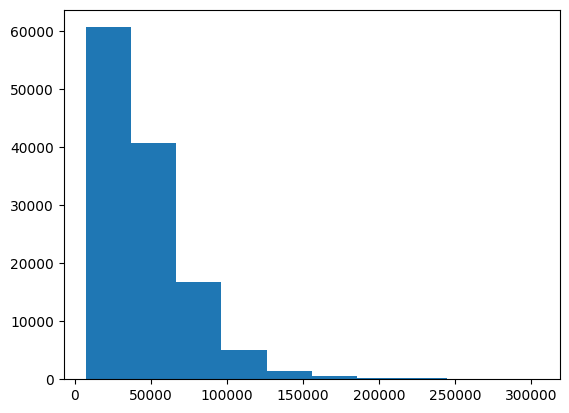

In [21]:
plt.hist(sample_sub['price'])